# Short-term Temperature Model Test

## Import dependencies and data

In [1]:
# import dependencies
import os
import json
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
import tensorflow as tf

from tensorflow.keras import layers, Model
from scipy.fftpack import fft, ifft, fftfreq

In [2]:
# define relevant paths
home_path = os.path.dirname(os.getcwd())
data_path = home_path + '\\data\\'
plot_path = home_path + '\\plotting\\plots\\'
save_path = home_path + '\\model\\saved\\'

In [90]:
# get merged data
data = pd.read_csv(
    data_path + 'data_merged.csv',
    header=[0, 1],
    index_col=[0, 1, 2, 3, 4]
)

# convert index.date col to datetime
#data.index = pd.to_datetime(data.index.values)
data.loc[:, ('time', 'date')] = pd.to_datetime(data.time.date)

In [91]:
# define X vars
x_vars = [
    ('flow', 'TA01_GP101'),
    ('state', 'TA01_output'),
    ('state', 'TA02_output'),
    ('temperatures', 'DC_GT101_GM101'),
    ('temperatures', 'DC_GT102_GM102'),
    ('temperatures', 'DC_GT103_GM103'),
    ('temperatures', 'DC_GT104_GM104'),
    ('temperatures', 'DC_GT401_GM401'),
    ('temperatures', 'TA01_GT401_GM401'),
    ('temperatures', 'TA02_GT401_GM401'),
    ('temperatures', 'DC_GT301_damped'),
    ('temperatures', 'DC_GT301_outdoor'),
    ('humidity', 'DC_GT101_GM101'),
    ('humidity', 'DC_GT102_GM102'),
    ('humidity', 'DC_GT103_GM103'),
    ('humidity', 'DC_GT104_GM104'),
    ('humidity', 'DC_GT401_GM401'),
    ('setpoints', 'TA01_GT10X_GM10X'),
    ('sun', 'gsi'),
    ('sun', 'gsi_deriv'),
    ('sun', 'vol'),
    ('sun', 'vol_deriv'),
    ('wind', 'Wx'),
    ('wind', 'Wy'),
    ('time', 'dayofyear'),
    ('time', 'monthofyear'),
    ('time', 'minofday'),
    ('time', 'hourofday')
]

# filter columns to keep only x_vars
data = data[x_vars].copy()

## Describe Df

In [92]:
# print number of NAs
print('Number of NAs\n')
print(data.isna().sum())
print('\n\n')

Number of NAs

category      sensor_ID       
flow          TA01_GP101          13
state         TA01_output         15
              TA02_output         14
temperatures  DC_GT101_GM101      12
              DC_GT102_GM102      12
              DC_GT103_GM103      11
              DC_GT104_GM104      11
              DC_GT401_GM401      13
              TA01_GT401_GM401    13
              TA02_GT401_GM401    12
              DC_GT301_damped     12
              DC_GT301_outdoor    12
humidity      DC_GT101_GM101      12
              DC_GT102_GM102      12
              DC_GT103_GM103      12
              DC_GT104_GM104      10
              DC_GT401_GM401      14
setpoints     TA01_GT10X_GM10X    14
sun           gsi                  3
              gsi_deriv            3
              vol                  3
              vol_deriv            3
wind          Wx                   3
              Wy                   3
time          dayofyear            3
              monthofyear    

In [93]:
# remove single NAN
data = data.dropna(how='any')

In [94]:
# # reduce to one OBS per MIN
data = data.groupby(['month', 'day', 'hour', 'minute'], sort=False).mean()

### Remove (clearly) erroneous measurements

In [95]:
# ## get flags for increase
# data[('flag', 'DC_GT102_GM102_temp')] = (data.temperatures.DC_GT102_GM102 - data.temperatures.DC_GT102_GM102.shift(10)) < -2
# data[('flag', 'DC_GT102_GM102_humid')] = (data.humidity.DC_GT102_GM102 - data.humidity.DC_GT102_GM102.shift(10)) > 20

# data[('flag', 'comb')] = data.flag.DC_GT102_GM102_temp & data.flag.DC_GT102_GM102_humid

In [96]:
# hrs = data.groupby(['month', 'day', 'hour']).sum()[('flag', 'comb')] > 0
# hrsDrop = hrs[hrs == 1].index.values
# mask = np.array([hrs not in list(hrsDrop) for hrs in data.index.droplevel(-1).values])
# data = data[mask]

In [97]:
# days = data.groupby(['month', 'day']).sum()[('flag', 'comb')] > 0
# daysDrop = days[days == 1].index.values
# mask = np.array([day not in list(daysDrop) for day in data.index.droplevel(-1).droplevel(-1).values])
# data = data[mask]

# Feature engineering

## Split TRAIN / TEST

In [98]:
## Randomly select days for trainin and testing
days = data.groupby(['month', 'day']).count().index.values

# get number of days f. testing / training
train_frac = 0.9
train_n = int(len(days) * train_frac)
test_n = len(days) - train_n

# split dataset
np.random.shuffle(days)
mask = np.array([day in list(days[:train_n]) for day in data.index.droplevel(-1).droplevel(-1).values])
data_train = data.loc[mask].copy()
data_test = data.loc[~mask].copy()

# del data

## NOISE reduction

### FFT f. TRAIN data

In [99]:
# cols = [
#     ('temperatures', 'DC_GT102_GM102'),
#     ('temperatures', 'DC_GT103_GM103'),
#     ('temperatures', 'DC_GT104_GM104'),
#     ('temperatures', 'DC_GT401_GM401'),
#     ('temperatures', 'TA01_GT401_GM401'),
#     ('temperatures', 'DC_GT301_outdoor'),
#     ('temperatures', 'DC_GT301_damped'),
#     ('humidity', 'DC_GT102_GM102'),
#     ('humidity', 'DC_GT103_GM103'),
#     ('humidity', 'DC_GT104_GM104'),
# ]

# for col in cols:
# #     sig_fft = fft(data.humidity[col].values)
#     sig_fft = fft(data_train[col].values)
#     sig_fft_filtered = sig_fft.copy()
#     sig_fft_noise = sig_fft.copy()
    
#     #
#     freq = fftfreq(len(data_train), d=1/5)
#     cut_off = 1
    
#     sig_fft_filtered[np.abs(freq) > cut_off] = 0
#     sig_fft_noise[np.abs(freq) <= cut_off] = 0
    
#     # get the filtered signal in time domain
#     filtered = ifft(sig_fft_filtered)

#     # put in data
# #     data.humidity.loc[:, col + '_noise'] = data.humidity[col]
#     data_train.loc[:, col] = filtered.astype('float64')

In [100]:
### create "better" estimate of temperature var, w. proper avg.
data_train[('temperatures', 'TA01_GT10X_GM10X')] = data_train.temperatures[[
    # ('DC_GT102_GM101'),
    ('DC_GT102_GM102'), 
    ('DC_GT103_GM103'), 
    ('DC_GT104_GM104')
]].values.mean(axis=1)

# adjust for setpoint change
data_train[('temperatures', 'TA01_GT10X_GM10X')] += (20.0 - data_train[('setpoints', 'TA01_GT10X_GM10X')])

In [101]:
### create "better" estimate of temperature var, w. proper avg.
data_train[('humidity', 'TA01_GT10X_GM10X')] = data_train.humidity[[
    # ('DC_GT102_GM101'),
    ('DC_GT102_GM102'), 
    ('DC_GT103_GM103'), 
    ('DC_GT104_GM104')
]].values.mean(axis=1)

### KALMAN f. TEST data

In [102]:
# cols = [
#     (('temperatures', 'DC_GT102_GM102'), 4),
#     (('temperatures', 'DC_GT103_GM103'), 4),
#     (('temperatures', 'DC_GT104_GM104'), 4),
#     (('temperatures', 'DC_GT401_GM401'), 3), #2),
#     (('temperatures', 'TA01_GT401_GM401'), 3),
#     (('temperatures', 'DC_GT301_outdoor'), 4),
#     (('temperatures', 'DC_GT301_damped'), 4),
#     (('humidity', 'DC_GT102_GM102'), 4),
#     (('humidity', 'DC_GT103_GM103'), 4),
#     (('humidity', 'DC_GT104_GM104'), 4),
# ]

# for colSpec in cols:
#     for day in data_test.groupby(['month', 'day']).count().index.values:
#         # apply KALMAN filter to measurements
#         col = colSpec[0]
#         varExp = colSpec[-1]

#         # get data
#         X = data_test.loc[day, col].values
#         n = len(X)

#         # process variance, measurement variance
#         Q = 1e-5
#         R = 0.1**varExp

#         xhat=np.zeros(n)      # a posteri estimate of x
#         P=np.zeros(n)         # a posteri error estimate
#         xhatminus=np.zeros(n) # a priori estimate of x
#         Pminus=np.zeros(n)    # a priori error estimate
#         K=np.zeros(n)         # gain or blending factor

#         # intial guesses
#         xhat[0] = X[0]
#         P[0] = 1

#         for k in range(1,n):
#             # time update
#             xhatminus[k] = xhat[k-1]
#             Pminus[k] = P[k-1]+Q

#             # measurement update
#             K[k] = Pminus[k]/( Pminus[k]+R )
#             xhat[k] = xhatminus[k]+K[k]*(X[k]-xhatminus[k])
#             P[k] = (1-K[k])*Pminus[k]

#         data_test.loc[day, col] = xhat

In [103]:
### create "better" estimate of temperature var, w. proper avg.
data_test[('temperatures', 'TA01_GT10X_GM10X')] = data_test.temperatures[[
    # ('DC_GT102_GM101'),
    ('DC_GT102_GM102'), 
    ('DC_GT103_GM103'), 
    ('DC_GT104_GM104')
]].values.mean(axis=1)


# adjust for setpoint change
data_test[('temperatures', 'TA01_GT10X_GM10X')] += (20.0 - data_test[('setpoints', 'TA01_GT10X_GM10X')])

In [104]:
### create "better" estimate of temperature var, w. proper avg.
data_test[('humidity', 'TA01_GT10X_GM10X')] = data_test.humidity[[
    # ('DC_GT102_GM101'),
    ('DC_GT102_GM102'), 
    ('DC_GT103_GM103'), 
    ('DC_GT104_GM104')
]].values.mean(axis=1)

### MIN / MAX scaling

In [105]:
# Define model variables
model_vars = [
    ('state', 'TA01_output'),
    ('state', 'TA02_output'),
    ('temperatures', 'TA01_GT10X_GM10X'),
    ('temperatures', 'DC_GT401_GM401'),
    ('temperatures', 'TA01_GT401_GM401'),
    ('temperatures', 'DC_GT301_damped'),
    ('humidity', 'TA01_GT10X_GM10X'),
    ('sun', 'gsi'),
    ('sun', 'gsi_deriv'),
    ('sun', 'vol'),
    ('sun', 'vol_deriv'),
#     ('wind', 'Wx'),
#     ('wind', 'Wy'),
    ('time', 'minofday'),
]

# filter data
data_train = data_train[model_vars].copy()
data_test = data_test[model_vars].copy()

In [106]:
col_params = {}
for col in data_train.columns:
    cat, var = col
    
    if cat == 'temperatures' and var == 'TA01_GT10X_GM10X':
        continue
    
    # make positive
    min_val = data_train[col].min()
    data_train[col] = data_train[col] + abs(min(0, min_val))
    min_val = max(0, min_val)
    max_val = data_train[col].max()
    data_train[col] = (data_train[col] - min_val) / (max_val - min_val)
    
    data_test[col] = data_test[col] + abs(min(0, min_val))
    data_test[col] = (data_test[col] - min_val) / (max_val - min_val)
    data_test[col] = data_test[col].apply(lambda val: max(min(val, 1.0), 0.0))
    
    col_params[col] = {
#         'mean':mean,
#         'std':std,
        'max':max_val,
        'min':min_val
    }

## Data preparation

In [107]:
t_steps = 10   # 10-min predictions
n_steps = 20   # 20-min backwards look

train_frac = 0.9

In [108]:
targets_train = data_train.pop(('temperatures', 'TA01_GT10X_GM10X')).copy()
targets_train = (targets_train - targets_train.shift(t_steps)) * 10

targets_test = data_test.pop(('temperatures', 'TA01_GT10X_GM10X')).copy()
targets_test = (targets_test - targets_test.shift(t_steps)) * 10

### Create sequences

In [109]:
def date_flagger(data, n_steps):
    # get flagged datesvalues
#     data['minute'] = data.index.get_level_values(3).values    
#     data['date_flag'] = data.minute - data.minute.shift(n_steps) != (n_steps)

    data['hour'] = data.index.get_level_values(2).values    
    data['date_flag'] = data.hour - data.hour.shift(n_steps) > 1
    
    # get positions in data, w.r.t. n_step removed observations at start
    flagged_idx = np.where(data.date_flag.values == 1)
    flagged_idx = flagged_idx[0] - n_steps
    
    del data['hour'], data['date_flag']
    
    return flagged_idx

In [110]:
def seq_maker(data, targets, n_steps):
    
    vals = data.values
    sequences = []
    for i in range(len(vals) - n_steps):
        sequences.append(vals[i:i+n_steps])
    sequences = np.stack(sequences)
    
    flags = date_flagger(data, n_steps)
    mask = [idx not in flags for idx in range(len(sequences))]
    
    sequences = sequences[mask]
    targets = targets[n_steps:][mask]
    
    return sequences, targets

In [111]:
# make sequences
sequences_train, targets_train = seq_maker(data_train, targets_train, n_steps)
sequences_test, targets_test = seq_maker(data_test, targets_test, n_steps)

In [112]:
targets_train = targets_train.values
targets_test = targets_test.values

In [113]:
# # shuffle training data randomly
# idxs = np.arange(len(targets_train))
# np.random.shuffle(idxs)

# sequences_train = sequences_train[idxs]
# targets_train = targets_train[idxs]

## Define LSTM Regressor

In [114]:
tf.keras.backend.clear_session()

In [115]:
layerList = [
    layers.Input(shape=(
        sequences_train.shape[1],
        sequences_train.shape[2]
    )),
    layers.LSTM(
        units=128,
        return_sequences=False,
        activation='tanh',
        recurrent_activation='sigmoid',
        activity_regularizer='l2',
        recurrent_dropout=0.2,
        #dropout=0.2,
        kernel_initializer=tf.keras.initializers.GlorotNormal(),
    ),
    layers.BatchNormalization(),
    layers.Dense(
        units=1,
        activation=None,
        activity_regularizer='l2'
    )
]

In [116]:
# layerList = [
#     layers.Input(shape=(
#         sequences_train.shape[1],
#         sequences_train.shape[2]
#     )),
#     layers.LSTM(
#         units=64,
#         return_sequences=True,
#         activation='tanh',
#         recurrent_activation='sigmoid',
#         activity_regularizer='l2',
#         recurrent_dropout=0.2,
#         #dropout=0.2,
#         kernel_initializer=tf.keras.initializers.GlorotNormal()
#     ),
#     layers.BatchNormalization(),
#     layers.LSTM(
#         units=32,
#         return_sequences=True,
#         activation='tanh',
#         recurrent_activation='sigmoid',
#         activity_regularizer='l2',
#         recurrent_dropout=0.5,
#         #dropout=0.5,
#         kernel_initializer=tf.keras.initializers.GlorotNormal()
#     ),
#     layers.BatchNormalization(),
#     layers.LSTM(
#         units=32,
# #         return_sequences=True,
#         activation='tanh',
#         recurrent_activation='sigmoid',
#         activity_regularizer='l2',
#         recurrent_dropout=0.5,
#         #dropout=0.5,
#         kernel_initializer=tf.keras.initializers.GlorotNormal()
#     ),
#     layers.BatchNormalization(),
#     layers.Dense(
#         units=1,
#         activation=None,
#         activity_regularizer='l2'
#     )
# ]

In [117]:
# lr = 0.005
lr = 0.001
# lr = 0.0005
model = tf.keras.models.Sequential(layers=layerList, name='model')
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr), loss="mse")
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 128)               71680     
                                                                 
 batch_normalization (BatchN  (None, 128)              512       
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 72,321
Trainable params: 72,065
Non-trainable params: 256
_________________________________________________________________


In [118]:
# model2 = tf.keras.models.load_model(save_path + 'temp_diff_model_v52')
# model2.summary()

In [119]:
# # copy weigths from pre-trained
# for idx, layer in enumerate(model.layers):
#     layer.set_weights(model2.layers[idx].get_weights())

In [120]:
trainHist = model.fit(
    sequences_train,
    targets_train,
    epochs=20,
    batch_size=128,
#     validation_split=0.0,
    validation_data = (sequences_test, targets_test),
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=10, mode="min"),
#         tf.keras.callbacks.LearningRateScheduler(lambda epoch: lr * (0.9 ** epoch))
    ],
)

Epoch 1/20
1460/1460 [==============================] - 72s 48ms/step - loss: 22.2371 - val_loss: 96.1650
Epoch 2/20
1460/1460 [==============================] - 78s 53ms/step - loss: 16.5903 - val_loss: 62.7107
Epoch 3/20
1460/1460 [==============================] - 85s 58ms/step - loss: 14.7979 - val_loss: 78.5967
Epoch 4/20
1460/1460 [==============================] - 85s 58ms/step - loss: 13.6817 - val_loss: 81.7731
Epoch 5/20
1460/1460 [==============================] - 85s 58ms/step - loss: 12.7874 - val_loss: 96.1880
Epoch 6/20
1460/1460 [==============================] - 85s 58ms/step - loss: 12.0985 - val_loss: 102.7834
Epoch 7/20
1460/1460 [==============================] - 85s 58ms/step - loss: 11.4541 - val_loss: 88.4523
Epoch 8/20
1460/1460 [==============================] - 85s 58ms/step - loss: 10.8801 - val_loss: 87.1400
Epoch 9/20
1460/1460 [==============================] - 85s 58ms/step - loss: 10.3864 - val_loss: 104.1412
Epoch 10/20
1460/1460 [=====================

KeyboardInterrupt: 

In [ ]:
# model_name = 'temp_diff_model_v203'
# model.save(save_path + model_name)

In [ ]:
# model = tf.keras.models.load_model(save_path + 'temp_diff_model_v202')
# model.summary()

In [121]:
preds = model.predict(sequences_test)

661/661 [==============================] - 6s 9ms/step


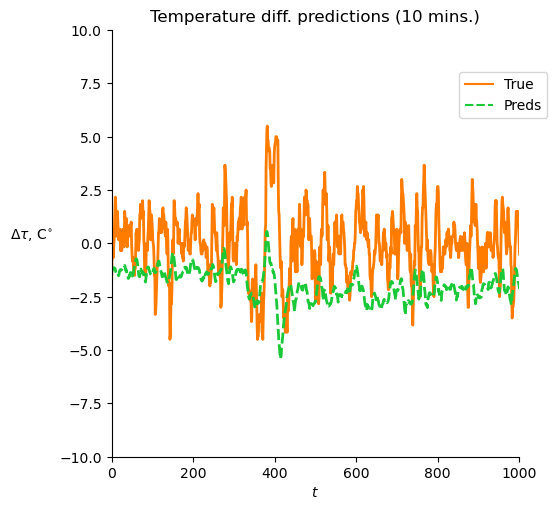

In [122]:
# preds_df = pd.DataFrame(data=[targets_test / 10, np.squeeze(preds) / 10]).T
preds_df = pd.DataFrame(data=[targets_test, np.squeeze(preds)+10]).T
preds_df.columns = ['True', 'Preds']
# preds_df.index = data.time.date.iloc[-5760:]

ax = sns.relplot(
    data=preds_df, #.iloc[:12000],
    kind='line',
    palette=sns.color_palette('bright')[1:3],
    linewidth=2.0,
    markers=False,
    dashes=True
)

# ax.set_xticklabels(step=2)
sns.move_legend(ax, loc='upper right', frameon=True, bbox_to_anchor=(0.9, 0.9))
plt.xlim(0, 1000)
plt.ylim(-10, 10)
plt.xlabel('$t$')
plt.ylabel('$\Delta \\tau$, C$^{\circ}$', rotation=0, labelpad=20)
plt.title('Temperature diff. predictions (10 mins.)')
# plt.savefig(plot_path + 'temp_diff_model_preds.png', bbox_inches='tight', dpi=200)
plt.show()

In [ ]:
# temp_diffs = np.abs(np.squeeze(vis_preds / 10) - test_targets / 10)
temp_diffs = (np.squeeze(preds) / 10) - (targets_test / 10)
# temp_diffs = (np.squeeze(preds) / 10) - (Y_test / 10)
diff_df = pd.DataFrame(temp_diffs)

sns.histplot(
    data=diff_df,
    stat='count',
    binwidth=0.05,
    binrange=[-2.0, 2.0],
    kde=False,
    palette=sns.color_palette('bright')[3:4],
    legend=False
)

plt.title('Distribution of errors')
plt.xlim(-2.0, 2.0)
plt.ylim(0, 1500)
plt.xlabel('$\Delta \\tau$ error, C$^\circ$')

plt.savefig(plot_path + 'temp_error_dist.png', bbox_inches='tight', dpi=200)
plt.show()

In [ ]:
preds_df = pd.DataFrame(np.squeeze(preds) / 10)
# preds_df = pd.DataFrame(np.squeeze(preds) / 10)

sns.histplot(
    data=preds_df,
    stat='count',
    binwidth=0.05,
    binrange=[-2.0, 2.0],
    kde=False,
    palette=sns.color_palette('bright')[2:3],
    legend=False
)

plt.title('Distribution of 10-minute forward predictions')
plt.xlim(-2.0, 2.0)
plt.ylim(0, 1500)
plt.xlabel('$\Delta \\tau$, C$^\circ$')

plt.savefig(plot_path + 'temp_preds_dist.png', bbox_inches='tight', dpi=200)
plt.show()

In [ ]:
sns.histplot(
    data=preds_df,
    stat='count',
    binwidth=0.05,
    binrange=[-2.0, 2.0],
    kde=False,
    palette=sns.color_palette('bright')[2:3],
    legend=False,
    label='Predictions'
)

sns.histplot(
    data=diff_df,
    stat='count',
    binwidth=0.05,
    binrange=[-2.0, 2.0],
    kde=False,
    palette=sns.color_palette('bright')[3:4],
    legend=False,
    label='Errors',
)

plt.title('Distribution of 10-minute forward predictions')
plt.xlim(-2.0, 2.0)
# plt.ylim(0, 1500)
plt.xlabel('$\Delta \\tau$, C$^\circ$')
plt.legend()

plt.savefig(plot_path + 'temp_both_dist.png', bbox_inches='tight', dpi=200)
plt.show()